In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar, os, io, base64
import statsmodels.api as sm
import datetime
from dateutil import relativedelta
import matplotlib 
import pandas_datareader as dt
import io, base64, os, json, re , math
import warnings
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split


In [13]:
history_bci=None
bci_df=None
history_bci=None
upcoming_forecast=None
bci_df_full=None
model_bci=None

def Startup():
    
    global history_bci,bci_df,upcoming_forecast_bci,bci_df_full,model_bci
    
    #load the cli data
    bci_raw=pd.read_csv('https://stats.oecd.org/sdmx-json/data/DP_LIVE/OECD.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
    bci_df=bci_raw[bci_raw['LOCATION'] =='OECD']

    full_date_list=[]
    for tm in bci_df['TIME']:
        year=int(tm.split('-')[0])
        month=int(tm.split('-')[1])
        #print calendar full date
        full_date_list.append(tm + '-'+str(calendar.monthrange(year,month)[1]))

    bci_df['Date'] = full_date_list
    bci_df['Date']= pd.to_datetime(bci_df['Date'])
    bci_df=bci_df[['Date','Value']]
    bci_df.index=bci_df['Date']

    bci_df_full=bci_df[['Date','Value']]
    bci_df_full = bci_df_full.set_index('Date')

    #Added learning columns

    prediction_months=12

    #Make a prediction column by shifting the values up by 12 months
    bci_df['Prediction']=bci_df[['Value']].shift(-prediction_months)

    #make several rollingMA to help the model learn better
    bci_df['7_months MA']=bci_df['Value'].rolling(window=7).mean()
    bci_df['4_months MA']=bci_df['Value'].rolling(window=4).mean()
    bci_df['2_months MA']=bci_df['Value'].rolling(window=2).mean()



    #drop the NaN values
    bci_cleaned=bci_df.dropna(subset=['7_months MA','4_months MA','2_months MA', 'Prediction'])

    #Get rid of the NAN values
    bci_cleaned.reset_index(drop=True, inplace=True)
    del bci_cleaned['Date']

    #Get the all the neccessary column values
    values=bci_cleaned[['Value','7_months MA','4_months MA','2_months MA','Prediction']]

    #change values to log form
    values=np.log(values)

    #change format to numpy array
    values=values.to_numpy()


    X=values[:,0:4]
    y=values[:,4:5]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    model_bci=Sequential()
    model_bci.add(Dense(200, input_dim=X.shape[1], activation='relu'))
    model_bci.add(Dense(200, activation='relu'))
    model_bci.add(Dense(1))

    model_bci.compile(loss='mean_squared_error', optimizer='adam')
    monitor=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=0)

    model_bci.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)
    
    history_bci=model_bci.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)

    #Forecast the next dates
    bci_df_full2=bci_df_full.copy()

    #make several rollingMA to help the model learn better
    bci_df_full2['7_months MA']=bci_df_full2['Value'].rolling(window=7).mean()
    bci_df_full2['4_months MA']=bci_df_full2['Value'].rolling(window=4).mean()
    bci_df_full2['2_months MA']=bci_df_full2['Value'].rolling(window=2).mean()

    #drop the NaN values in all columns
    bci_df_full2=bci_df_full2.dropna(subset=['7_months MA','4_months MA','2_months MA'])

    #Reset the index column and delete the date columns
    bci_df_full2.reset_index(drop=True, inplace=True)
    #del cci_df_full2['Date']

    #change values to log form
    bci_df_full2=np.log(bci_df_full2)
    #change format to numpy array
    bci_df_full2=bci_df_full2.to_numpy()
    #Get only the last 12 months datapoints
    bci_df_full2=bci_df_full2[-12:]

    upcoming_forecast_bci= model.predict(bci_df_full2)
    
    
    
def GetForecast(months_out3):
    
    forwarded_dates=[]
    year=2020
    for i in range(5,13):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
    year=2021
    for i in range(1,5):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
        
        
    #append forecasted dates to dataframe
    df_forecast=pd.DataFrame(forwarded_dates)
    df_forecast.columns=['Date']
    
    
    upcoming_f=np.exp(upcoming_forecast_bci)
    upcoming_f=pd.DataFrame(upcoming_f)

    df_forecast['Value']=upcoming_f
    #set column as datetime
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
    #set index as date
    df_forecast = df_forecast.set_index('Date')
    
    last_date=bci_df_full.tail(1)
    df_forecast=df_forecast.append(last_date)
    df_forecast=df_forecast.drop_duplicates()
    df_forecast = df_forecast.sort_index()
    
    fig,ax=plt.subplots(figsize=(16,10))
    plt.plot(df_forecast.head(months_out3+1), label='Neural Net model')
    plt.plot(bci_df_full, label='Actual')
    
    ax.axhline(y=100,color='gray')
    plt.legend(loc='best')
    plt.title('BCI Forecast Util ')
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 0.5))
    plt.grid()

    plt.show()


In [14]:
Startup()

Train on 357 samples, validate on 176 samples
Epoch 1/250
357/357 [==============================] - 1s 2ms/sample - loss: 1.8672 - val_loss: 0.0061
Epoch 2/250
357/357 [==============================] - 0s 115us/sample - loss: 0.2619 - val_loss: 0.0205
Epoch 3/250
357/357 [==============================] - 0s 123us/sample - loss: 0.0800 - val_loss: 0.0391
Epoch 4/250
357/357 [==============================] - 0s 118us/sample - loss: 0.0286 - val_loss: 0.0234
Epoch 5/250
357/357 [==============================] - 0s 115us/sample - loss: 0.0088 - val_loss: 0.0039
Epoch 6/250
357/357 [==============================] - 0s 123us/sample - loss: 0.0019 - val_loss: 2.0717e-04
Epoch 7/250
357/357 [==============================] - 0s 120us/sample - loss: 6.9154e-04 - val_loss: 7.0335e-04
Epoch 8/250
357/357 [==============================] - 0s 134us/sample - loss: 3.4948e-04 - val_loss: 1.4112e-04
Epoch 9/250
357/357 [==============================] - 0s 112us/sample - loss: 1.9016e-04 - val_

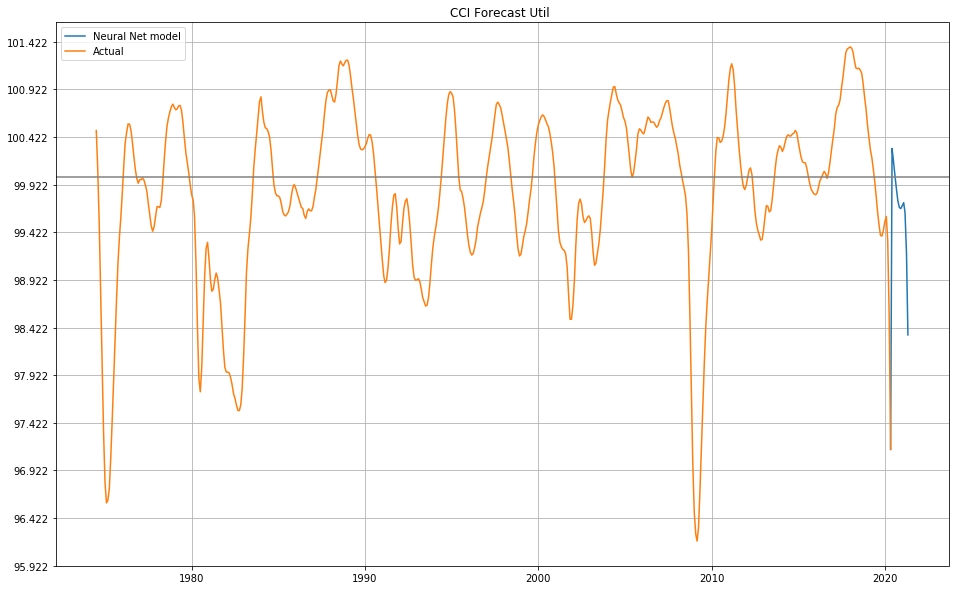

In [15]:
GetForecast(12)